In [12]:
from scipy.io import loadmat
import numpy as np
import numpy.ma as ma
import utilities_figures as ufig
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Plot 1: Night selection
data_mat_ID11 = loadmat('../data/ID11_all_fs64.mat')
data_mat_ID12 = loadmat('../data/ID12_all_fs64.mat')
fs_all = 64
x11 = data_mat_ID11['data'].flatten()
x12 = data_mat_ID12['data'].flatten()

f11, t11, Sxx11 = signal.spectrogram(x11, fs=fs_all, nperseg=int(2*60*fs_all), noverlap=0, nfft=int(2*60*fs_all), scaling='density')
f12, t12, Sxx12 = signal.spectrogram(x12, fs=fs_all, nperseg=int(2*60*fs_all), noverlap=0, nfft=int(2*60*fs_all), scaling='density')
x11 = []
x12 = []

In [13]:
# Plot 2: Segment selection
data_mat = loadmat('../data/ID11_59to65h.mat')
info = loadmat('../data/ID11_info.mat')
fs = float(info['fs'])
data = data_mat['EEG'][2]
data_mat = []

# Parameters
sw_band = (0.5, 4)
nperseg = int(20*fs)
noverlap = int(10*fs)
h_offset = 59

# Load detections from visbrain
det_dict = np.load('../data/detections_ID11a.npy', allow_pickle=True).item()
spindles = det_dict['ch00', 'Spindles']['index']/102.4
spindles_mean = np.mean(spindles, axis=1)
k_complexes = det_dict['ch00', 'K-complexes']['index']/102.4
k_complexes_mean = np.mean(k_complexes, axis=1)

# Get spectral density
f, t, Sxx = signal.spectrogram(data, fs, nperseg=nperseg, noverlap=noverlap, scaling='density')

# Extract slow wave band with tukey window
Sxx_band = Sxx[int(sw_band[0] * Sxx.shape[0] / f[-1]):int(sw_band[1] * Sxx.shape[0] / f[-1]), :]
tukey_window_band = np.tile(signal.tukey(Sxx_band.shape[0]), (Sxx_band.shape[1], 1)).T
Sxx_band_tukey = np.multiply(Sxx_band,  tukey_window_band)

# Compute average band power
swa = np.mean(Sxx_band_tukey, axis=0)

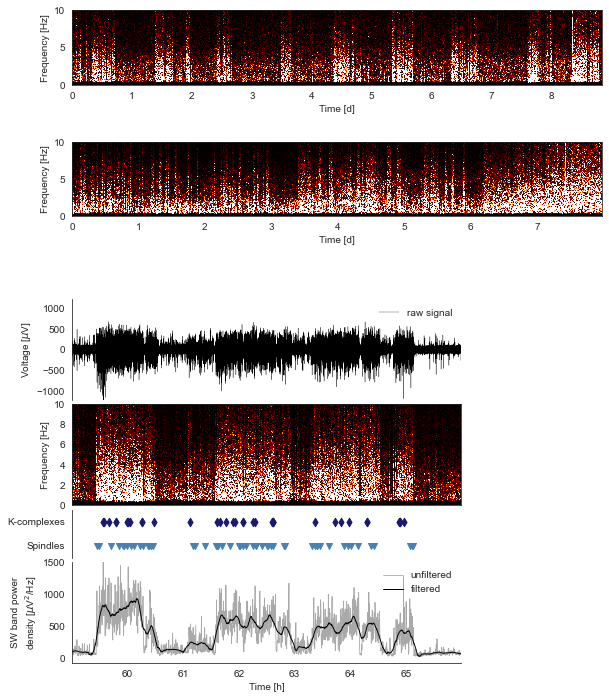

In [4]:
sns.set_style('white')
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(25, 20)
t_spect = t/60/60 + h_offset
t_sig = np.linspace(h_offset, t_spect[-1], data.shape[0])

ax0 = fig.add_subplot(gs[:3, :19])
ax0.set_ylim(0, 10)
t_h11 = np.linspace(0, t11[-1]/60/60/24, t11.shape[0])
plt.pcolormesh(t_h11, f11, Sxx11, vmax=500, cmap='gist_heat', shading='auto')
ax0.set_xlabel('Time [d]'), ax0.set_ylabel('Frequency [Hz]')
ax0.xaxis.set_ticks(np.arange(0, 9))
#cb = plt.colorbar()
#cb.set_label(label='Power spectral density [uV^2/Hz]')

ax1 = fig.add_subplot(gs[5:8, :19])
ax1.set_ylim(0, 10)
t_h12 = np.linspace(0, t12[-1]/60/60/24, t12.shape[0])
plt.pcolormesh(t_h12, f12, Sxx12, vmax=500, cmap='gist_heat', shading='auto')
ax1.set_xlabel('Time [d]'), ax1.set_ylabel('Frequency [Hz]')
#cb = plt.colorbar()
#cb.set_label(label='Power spectral density [uV^2/Hz]')

ax2 = fig.add_subplot(gs[11:15, :14])
ax2.set_ylim(-1200, 1200)
plt.plot(t_sig, data.flatten(), color='black', label='raw signal', lw=.3)
ax2.set_xlim(t_sig[0], t_sig[-1])
ax2.set_xlabel('Time [h]'), ax2.set_ylabel('Voltage [$\mu$V]')
plt.legend(loc='upper right', frameon=False)
ax2.spines['right'].set_visible(False), ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.get_xaxis().set_visible(False)

ax3 = fig.add_subplot(gs[15:19, :14])
ax3.set_ylim(0, 10)
plt.pcolormesh(t_spect, f, Sxx, vmax=500, cmap='gist_heat', shading='auto')
ax3.set_xlabel('Time [h]'), ax3.set_ylabel('Frequency [Hz]')
ax3.set_xlim(t_spect[0], t_spect[-1])
ax3.get_xaxis().set_visible(False)
#cb = plt.colorbar()
#cb.set_label(label='Power spectral density [uV^2/Hz]')

ax4 = fig.add_subplot(gs[19:21, :14])
plt.scatter(spindles_mean/60/60 + h_offset, np.zeros(len(spindles)), marker='v', color='steelblue')
plt.scatter(k_complexes_mean/60/60 + h_offset, np.ones(len(k_complexes)), marker='d', color='midnightblue')
ax4.spines['right'].set_visible(False), ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.set_yticks([0, 1]), ax4.set_yticklabels(['Spindles', 'K-complexes'])
ax4.set_ylim(-.5, 1.5)
ax4.set_xlim(t_sig[0], t_sig[-1])
ax4.get_xaxis().set_visible(False)

ax5 = fig.add_subplot(gs[21:25, :14])
plt.plot(t_spect, swa, lw=.8, color='darkgrey', label='unfiltered')
smooth = signal.savgol_filter(swa, window_length=101, polyorder=3)
plt.plot(t_spect, smooth, c='black', lw=1, label='filtered')
plt.legend(loc='upper right', frameon=False)
ax5.set_xlim(t_spect[0], t_spect[-1])
ax5.set_ylim(top=1500)
ax5.set_ylabel('SW band power\ndensity [$\mu$V$^2$/Hz]')
ax5.set_xlabel('Time [h]')
ax5.spines['right'].set_visible(False), ax5.spines['top'].set_visible(False)

plt.savefig('figures/Ch2_DataSelection_a.png', dpi=500)

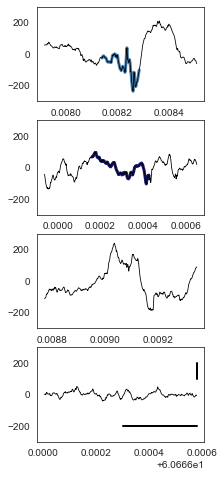

In [14]:
spindles_pos = 10
oversize = int(.8*fs)
begin = int(spindles[spindles_pos, 0]*fs)
end = int(spindles[spindles_pos, 1]*fs)
y_lim = 300

fig, ax = plt.subplots(4, 1, figsize=(3, 8))

ax[0].plot(t_sig[begin:end], data[begin:end], color='steelblue', lw=3)
ax[0].plot(t_sig[begin - oversize:end + oversize], data[begin - int(.8*fs):end + int(.8*fs)], color='black', lw=.8)

ax[0].set_ylim(-y_lim, y_lim)


k_complexes_pos = 19
oversize = int(.8*fs)
begin = int(k_complexes[k_complexes_pos, 0]*fs)
end = int(k_complexes[k_complexes_pos, 1]*fs)

ax[1].plot(t_sig[begin:end], data[begin:end], color='midnightblue', lw=3)
ax[1].plot(t_sig[begin - oversize:end + oversize], data[begin - int(.8*fs):end + int(.8*fs)], color='black', lw=.8)
#ax[1, 0].plot([t_sig[begin - oversize], t_sig[begin - oversize]], [100, 200], lw=3, color='black')
#ax[1, 0].plot([t_sig[begin - oversize], t_sig[begin - oversize] + 0.0001], [-200, -200], lw=3, color='black')
ax[1].set_ylim(-y_lim, y_lim)

begin = int(3597*fs)
duration = int((t_sig[end + oversize] - t_sig[begin - oversize]) * fs)
end = begin + duration

ax[2].plot(t_sig[begin:end], data[begin:end], color='black', lw=.8)
ax[2].set_ylim(-y_lim, y_lim)

begin = int(6000*fs)
end = begin + duration
ax[3].plot(t_sig[begin:end], data[begin:end], color='black', lw=.8)
ax[3].set_ylim(-y_lim, y_lim)
ax[3].plot([t_sig[end] - 1/60/60, t_sig[end]], [-200, -200], lw=2, color='black')
ax[3].plot([t_sig[end], t_sig[end]], [100, 200], lw=2, color='black')
plt.savefig('figures/Ch2_DataSelection_b_alternative_3.png', dpi=500)

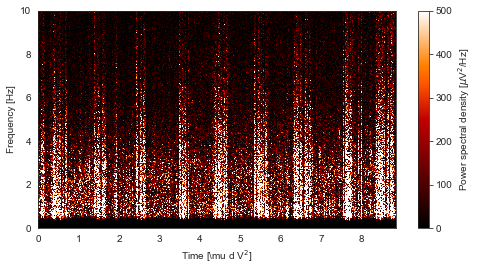

In [8]:
sns.set_style('white')
fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[:, :])
ax0.set_ylim(0, 10)
t_h11 = np.linspace(0, t11[-1]/60/60/24, t11.shape[0])
plt.pcolormesh(t_h11, f11, Sxx11, vmax=500, cmap='gist_heat', shading='auto')
ax0.set_xlabel('Time [\mu d V$^2$]'), ax0.set_ylabel('Frequency [Hz]')
cb = plt.colorbar()
cb.set_label(label='Power spectral density [$\mu$V$^2$/Hz]')
plt.savefig('figures/Ch2_DataSelection_c.png', dpi=500)

In [15]:
k_complexes_mean[0]/60/60 + h_offset

59.550191243489586

In [14]:
t_sig[0]

59.0

In [23]:
t_h11 = np.linspace(0, t11[-1]/60/60/24, t11.shape[0])

In [27]:
t12[-1]/60/60/24

7.9743055555555555

In [10]:
sns.set_style('white')
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(24, 16)
t_spect = t/60/60 + h_offset
t_sig = np.linspace(h_offset, t_spect[-1], data.shape[0])

<Figure size 864x576 with 0 Axes>

In [8]:
t_sig[begin - oversize]

60.665783275751664

In [5]:
sns.set_style('white')
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(25, 20)
t_spect = t/60/60 + h_offset
t_sig = np.linspace(h_offset, t_spect[-1], data.shape[0])

<Figure size 720x864 with 0 Axes>

In [19]:
np.arange(0, 8)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [12]:
1/0.36

2.7777777777777777